# Introduction

I have chosen two data sets, one regression and one a binary classification.  (The assignment mentions two classifications, but Prof. Isbell answered a student's question about this with "You can do regression if you want to. I appreciate the claim that’s it’s all classification under finite data.")



In [1]:
# run this if category_encoders (used below) is not installed
# import sys
# !conda install --yes --prefix {sys.prefix} category_encoders
# !conda install --yes --prefix {sys.prefix} xgboost
#!pip install category_encoders
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as skl
import seaborn as sns
import matplotlib as plt

# Supervised Learning Data Set 1 (Cars)

This dataset is a (scraped) listing of used cars with their features and selling prices.  It is being used to predict the selling price of a used car with certain features.

First we read in and examine the data set briefly.

In [3]:
np.random.seed(5295468)
cars_df = pd.read_csv('data/car_prices.csv')
print("cars_df shape = {}".format(cars_df.shape))
cars_df.head()

cars_df shape = (11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


Seeing the irregularity of the column names, normalize them to lowercase with _ separating words.

In [4]:
def normalize_column_names(df):
    df.columns = cars_df.columns.str.lower().str.replace(' ', '_')
    string_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')
        df[col] = df[col].str.lower().str.replace('-', '_')

normalize_column_names(cars_df)
cars_df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high_performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high_performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## Data Prep (Attempt 1)

I won't reiterate the importance of preparing the data.

-- "Without a systematic way to start and keep data clean, bad data will happen.” — Donato Diorio

###  Re-encoding the Data

The market category is a comma separated multi-selection fiel|d, which doesn't encode well.

We create one-hot encoded columns for each value in the column for each sample.  The downside is that most of the samples don't have a category assigned, so we may end up dropping this to see if it improves the accuracy at all.

The other categorical columns we encode using a Leave One Out encoder[^leave-one-out] to bring them to a numerical representation without exploding the number of features.

[^leave-one-out] https://contrib.scikit-learn.org/category_encoders/leaveoneout.html

In [5]:
from category_encoders import LeaveOneOutEncoder

cars_df['market_category'] = cars_df['market_category'].fillna('unknown')
unique_categories = list(cars_df['market_category'].unique())
single_categories = {}
for cats in unique_categories:
    split_cats = cats.split(',')
    for cat in split_cats:
        single_categories[cat] = 1
for cat in single_categories.keys():
    cars_df[cat] = 0
    cars_df.loc[cars_df['market_category'].str.find(cat) != -1, cat] = 1
del cars_df['market_category']
enc = LeaveOneOutEncoder(cols=['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'vehicle_style'], sigma=0.05)
msrp = cars_df['msrp']
cars_df = enc.fit_transform(cars_df[cars_df.columns.difference(['msrp'])], cars_df['msrp'])
cars_df['msrp'] = msrp
cars_df.head()

c:\python3.9\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,city_mpg,crossover,diesel,driven_wheels,engine_cylinders,engine_fuel_type,engine_hp,exotic,factory_tuner,flex_fuel,...,model,number_of_doors,performance,popularity,transmission_type,unknown,vehicle_size,vehicle_style,year,msrp
0,19,0,0,54509.568880,6.0,104174.319216,335.0,0,1,0,...,39893.794974,2.0,1,3916,26515.792573,0,35734.242986,69028.743603,2011,46135
1,19,0,0,55202.393232,6.0,106043.780241,300.0,0,0,0,...,38046.062616,2.0,1,3916,26228.751544,0,34719.328629,94719.337541,2011,40650
2,20,0,0,47188.326365,6.0,110015.759342,300.0,0,0,0,...,37608.541828,2.0,1,3916,26954.973923,0,37142.785074,75810.619046,2011,36350
3,18,0,0,53116.920262,6.0,102736.696718,230.0,0,0,0,...,40370.003185,2.0,1,3916,26243.424651,0,35472.895602,71997.856596,2011,29450
4,18,0,0,57493.813855,6.0,107971.587679,230.0,0,0,0,...,38816.838751,2.0,0,3916,27696.029584,0,35688.465635,83708.645015,2011,34500


### Correlations

Next, we map out the correlations in the data.  This may prove useful if we need to reduce the number of features later. Reducing the features by eliminating features that already are represented by other features through their correlations is a good start.

Here's why that's important:

"It turns out that many things behave very differently in high-dimensional space. For
example, if you pick a random point in a unit square (a 1 × 1 square), it will have only
about a 0.4% chance of being located less than 0.001 from a border (in other words, it
is very unlikely that a random point will be “extreme” along any dimension). But in a
10,000-dimensional unit hypercube, this probability is greater than 99.999999%. Most
points in a high-dimensional hypercube are very close to the border."

"Here is a more troublesome difference: if you pick two points randomly in a unit
square, the distance between these two points will be, on average, roughly 0.52. If you
pick two random points in a unit 3D cube, the average distance will be roughly 0.66.
But what about two points picked randomly in a 1,000,000-dimensional hypercube?
The average distance, believe it or not, will be about 408.25 (roughly 1, 000, 000/6)!
This is counterintuitive: how can two points be so far apart when they both lie within
the same unit hypercube? Well, there’s just plenty of space in high dimensions. As a
result, high-dimensional datasets are at risk of being very sparse: most training
instances are likely to be far away from each other. This also means that a new
instance will likely be far away from any training instance, making predictions much
less reliable than in lower dimensions, since they will be based on much larger extrap‐
olations. In short, the more dimensions the training set has, the greater the risk of
overfitting it."

"In theory, one solution to the curse of dimensionality could be to increase the size of
the training set to reach a sufficient density of training instances. Unfortunately, in
practice, the number of training instances required to reach a given density grows
exponentially with the number of dimensions. With just 100 features (significantly
fewer than in the MNIST problem), you would need more training instances than
atoms in the observable universe in order for training instances to be within 0.1 of
each other on average, assuming they were spread out uniformly across all dimen‐
sions."[^curse-of-dimensionality]

[^curse-of-dimensionality]: Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly.

<AxesSubplot:>

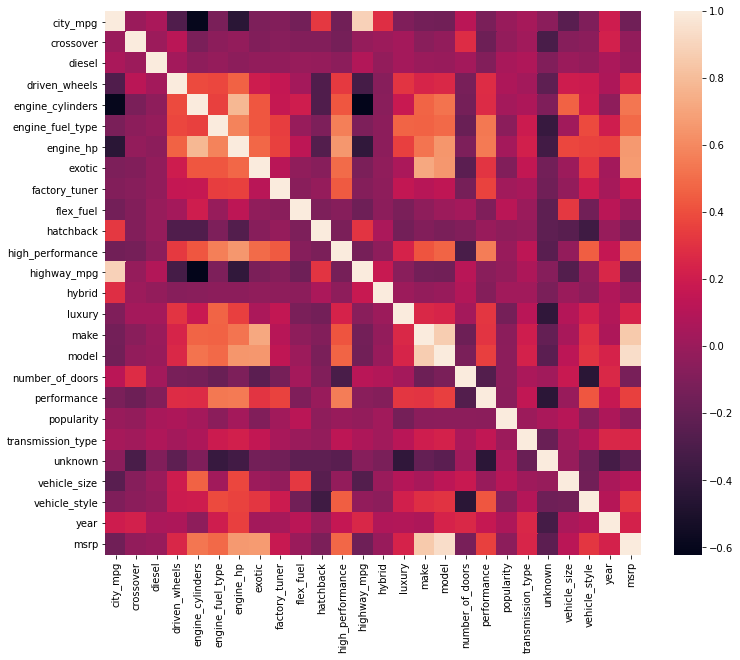

In [6]:
cars_corr = cars_df.corr()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.heatmap(data=cars_corr, ax=ax)

Here we see there are a number of columns that are highly correlated between each other.  Let's put this into a list form to make it easier to distinguish.

In [7]:
correlations_already = []
for t in cars_corr.itertuples():
    index = ''
    for k, v in t._asdict().items():
        if(k == 'Index'):
            index = v
            continue
        if(index == k or k == 'msrp' or index == 'msrp'):
            continue
        if(abs(v) > 0.6 and (index, k) not in correlations_already):
            print("{} and {} are highly (inversely) correlated ({})".format(index, k, v))
            correlations_already.append((index, k))
            correlations_already.append((k, index))

city_mpg and engine_cylinders are highly (inversely) correlated (-0.6007763119730489)
city_mpg and highway_mpg are highly (inversely) correlated (0.8868294962591425)
engine_cylinders and engine_hp are highly (inversely) correlated (0.7799879704685257)
engine_cylinders and highway_mpg are highly (inversely) correlated (-0.6216057332861783)
engine_hp and high_performance are highly (inversely) correlated (0.6557040157675598)
engine_hp and model are highly (inversely) correlated (0.646005344927799)
exotic and make are highly (inversely) correlated (0.7161338704725522)
exotic and model are highly (inversely) correlated (0.6550931579727469)
make and model are highly (inversely) correlated (0.8691867845850091)


These correlations come with a bonus: data validation.  When validating new data entered by users or other sources, we can check whether the new data correlates in a similar manner.  If it doesn't, it is probably erroneous, and flag it for review.

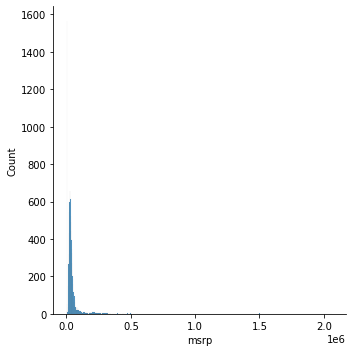

In [8]:
sns.displot(cars_df.msrp, kde=False)

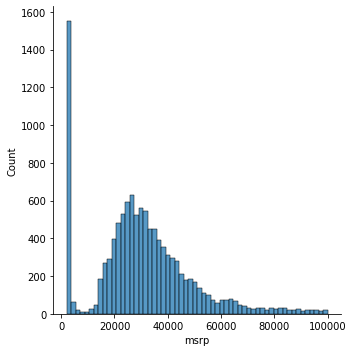

In [9]:
sns.displot(cars_df.msrp[cars_df.msrp < 100000], kde=False)

We need to normalize these a bit.  Let's try Box-Cox and logarithm transformations to see what the distribution looks like.

In [10]:
boxcox_prices = sp.stats.boxcox(cars_df.msrp)
log_prices = np.log1p(cars_df.msrp)

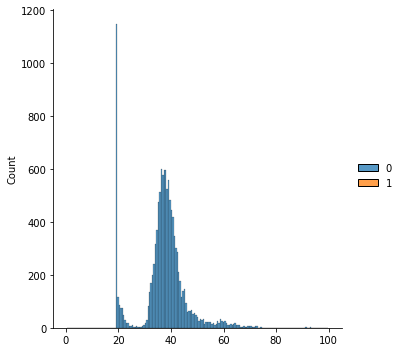

In [11]:
sns.displot(boxcox_prices, kde=False)

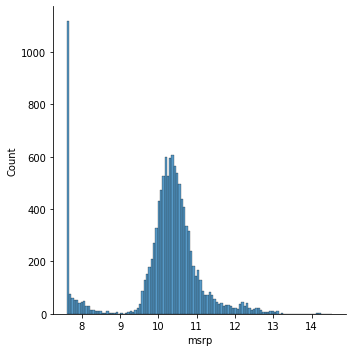

In [12]:
sns.displot(log_prices, kde=False)

It looks like the logarithm transformation is a bit more normal, where the tails are not as long and a little flatter on the left side.  We'll stick with that one.

In [13]:
cars_df.head()

,city_mpg,crossover,diesel,driven_wheels,engine_cylinders,engine_fuel_type,engine_hp,exotic,factory_tuner,flex_fuel,...,model,number_of_doors,performance,popularity,transmission_type,unknown,vehicle_size,vehicle_style,year,msrp
0,19,0,0,54509.568880,6.0,104174.319216,335.0,0,1,0,...,39893.794974,2.0,1,3916,26515.792573,0,35734.242986,69028.743603,2011,46135
1,19,0,0,55202.393232,6.0,106043.780241,300.0,0,0,0,...,38046.062616,2.0,1,3916,26228.751544,0,34719.328629,94719.337541,2011,40650
2,20,0,0,47188.326365,6.0,110015.759342,300.0,0,0,0,...,37608.541828,2.0,1,3916,26954.973923,0,37142.785074,75810.619046,2011,36350
3,18,0,0,53116.920262,6.0,102736.696718,230.0,0,0,0,...,40370.003185,2.0,1,3916,26243.424651,0,35472.895602,71997.856596,2011,29450
4,18,0,0,57493.813855,6.0,107971.587679,230.0,0,0,0,...,38816.838751,2.0,0,3916,27696.029584,0,35688.465635,83708.645015,2011,34500


In [14]:
cars_df['msrp'] = np.log1p(cars_df['msrp'])

The rows with NaN are dropped. The counts are not too high, accounting for only 0.8% of the total data, not enough to make a significant difference.

In [15]:
cars_df.isnull().sum()

city_mpg              0
crossover             0
diesel                0
driven_wheels         0
engine_cylinders     30
engine_fuel_type      0
engine_hp            69
exotic                0
factory_tuner         0
flex_fuel             0
hatchback             0
high_performance      0
highway_mpg           0
hybrid                0
luxury                0
make                  0
model                 0
number_of_doors       6
performance           0
popularity            0
transmission_type     0
unknown               0
vehicle_size          0
vehicle_style         0
year                  0
msrp                  0
dtype: int64

In [16]:
cars_df = cars_df.dropna()
if 'unknown' in cars_df.keys():
    del cars_df['unknown']

Now that all the columns are converted to a numeric representation, scale the columns to a standard scale of 0 to 1.  This should help eliminate weighting too much based on a column, and it will make things more easy to compare.

We may change this to use the StandardScaler to test if our accuracy improves.

This page shows the importance of scaling: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py.  In particular, "many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized".

This page shows how to use the scalers: https://androidkt.com/how-to-normalize-scale-standardize-pandas-dataframe-columns-using-scikit-learn/

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler() # MinMaxScaler()
cars_df_scaled = pd.DataFrame(scaler.fit_transform(cars_df))
cars_df_scaled.columns = cars_df.columns
cars_df_scaled

,city_mpg,crossover,diesel,driven_wheels,engine_cylinders,engine_fuel_type,engine_hp,exotic,factory_tuner,flex_fuel,...,make,model,number_of_doors,performance,popularity,transmission_type,vehicle_size,vehicle_style,year,msrp
0,-0.050186,-0.454936,-0.13288,0.872292,0.200123,2.133668,0.783154,-0.20623,4.256539,-0.33482,...,0.356431,-0.005122,-1.622841,1.555214,1.640774,-0.911364,-0.617261,1.455908,0.084281,0.567811
1,-0.050186,-0.454936,-0.13288,0.915754,0.200123,2.196338,0.462638,-0.20623,-0.234933,-0.33482,...,0.507996,-0.037274,-1.622841,1.555214,1.640774,-0.929944,-0.745617,2.770998,0.084281,0.453622
2,0.103030,-0.454936,-0.13288,0.413016,0.200123,2.329492,0.462638,-0.20623,-0.234933,-0.33482,...,0.442365,-0.044887,-1.622841,1.555214,1.640774,-0.882935,-0.439123,1.803069,0.084281,0.352757
3,-0.203402,-0.454936,-0.13288,0.784929,0.200123,2.085474,-0.178395,-0.20623,-0.234933,-0.33482,...,0.446666,0.003164,-1.622841,1.555214,1.640774,-0.928995,-0.650314,1.607896,0.084281,0.162855
4,-0.203402,-0.454936,-0.13288,1.059500,0.200123,2.260964,-0.178395,-0.20623,-0.234933,-0.33482,...,0.391320,-0.023862,-1.622841,-0.642998,1.640774,-0.834965,-0.623051,2.207365,0.084281,0.305634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11810,-0.509834,2.198110,-0.13288,1.186992,0.200123,1.978288,0.462638,-0.20623,-0.234933,-0.33482,...,-0.097939,0.177891,0.642636,-0.642998,-0.937137,-0.095517,0.242962,-0.886330,0.215963,0.567517
11811,-0.509834,2.198110,-0.13288,0.663779,0.200123,1.903154,0.462638,-0.20623,-0.234933,-0.33482,...,-0.111258,0.200031,0.642636,-0.642998,-0.937137,-0.054984,-0.379416,-0.929406,0.215963,0.753360
11812,-0.509834,2.198110,-0.13288,1.209599,0.200123,2.077478,0.462638,-0.20623,-0.234933,-0.33482,...,-0.126102,0.226877,0.642636,-0.642998,-0.937137,0.157102,-0.091215,-0.929311,0.215963,0.651508
11813,-0.509834,2.198110,-0.13288,1.509200,0.200123,0.012759,0.462638,-0.20623,-0.234933,-0.33482,...,-0.075792,0.181417,0.642636,-0.642998,-0.937137,0.002418,-0.495835,-0.948520,0.347646,0.656839


## Feature Reduction

We then use PCA to examine the variance in the data set and see who much we may eliminate without reducing the various too much.
https://datascience.stackexchange.com/questions/47324/curse-of-dimensionality-how-many-dimensions-is-too-many-dimensions


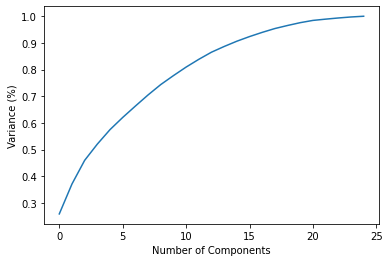

In [18]:
#Fitting the PCA algorithm with our Data
from sklearn.decomposition import PCA 
pca = PCA().fit(cars_df_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

Based on this, it looks like we could cut our features down to 15 with no significant loss of variance.  What columns to get rid of?  The highly (inversly) correlated ones of course!

Well, maybe not.  It seems that quite a few of the columns are still necessary based on criteria.

```
city_mpg and engine_cylinders are highly (inversely) correlated (-0.6007763119730489)
city_mpg and highway_mpg are highly (inversely) correlated (0.8868294962591425)
engine_cylinders and engine_hp are highly (inversely) correlated (0.7799879704685257)
engine_cylinders and highway_mpg are highly (inversely) correlated (-0.6216057332861783)
engine_hp and high_performance are highly (inversely) correlated (0.6557040157675598)
engine_hp and model are highly (inversely) correlated (0.646005344927799)
exotic and make are highly (inversely) correlated (0.7161338704725522)
exotic and model are highly (inversely) correlated (0.6550931579727469)
make and model are highly (inversely) correlated (0.8691867845850091)
```

We can likely collapse the city and highway mpg into a single column, mpg, by taking their average.

Also, horse power and cylinders are highly correlated, so we could get rid of one of them.  Looking at common criteria on car shopping websites, hp is less frequent, so we'll ditch that one too.

Also, some of the market segment columns don't seem to be doing much for us.  `Exotic` is highly correlated, as is `high_performance`.

That brings us to 4 eliminated.  If we eliminate some of the other market segment one hot columns, such as `luxury`, `factory_tuner`.  `flex_fuel` and `diesel` are covered by `engine_fuel_type`, so that brings us to 17, which is just where the PCA variance starts to curve.

In [19]:
cars_df_scaled['mpg'] = (cars_df_scaled['highway_mpg'] + cars_df_scaled['city_mpg']) / 2.0
cars_df_scaled.drop(['exotic', 'city_mpg', 'highway_mpg', 'high_performance', 'luxury', 'factory_tuner', 'flex_fuel', 'diesel'], axis = 1)

,crossover,driven_wheels,engine_cylinders,engine_fuel_type,engine_hp,hatchback,hybrid,make,model,number_of_doors,performance,popularity,transmission_type,vehicle_size,vehicle_style,year,msrp,mpg
0,-0.454936,0.872292,0.200123,2.133668,0.783154,-0.333255,-0.172913,0.356431,-0.005122,-1.622841,1.555214,1.640774,-0.911364,-0.617261,1.455908,0.084281,0.567811,-0.046632
1,-0.454936,0.915754,0.200123,2.196338,0.462638,-0.333255,-0.172913,0.507996,-0.037274,-1.622841,1.555214,1.640774,-0.929944,-0.745617,2.770998,0.084281,0.453622,0.087734
2,-0.454936,0.413016,0.200123,2.329492,0.462638,-0.333255,-0.172913,0.442365,-0.044887,-1.622841,1.555214,1.640774,-0.882935,-0.439123,1.803069,0.084281,0.352757,0.164342
3,-0.454936,0.784929,0.200123,2.085474,-0.178395,-0.333255,-0.172913,0.446666,0.003164,-1.622841,1.555214,1.640774,-0.928995,-0.650314,1.607896,0.084281,0.162855,0.011126
4,-0.454936,1.059500,0.200123,2.260964,-0.178395,-0.333255,-0.172913,0.391320,-0.023862,-1.622841,-0.642998,1.640774,-0.834965,-0.623051,2.207365,0.084281,0.305634,0.011126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11810,2.198110,1.186992,0.200123,1.978288,0.462638,3.000706,-0.172913,-0.097939,0.177891,0.642636,-0.642998,-0.937137,-0.095517,0.242962,-0.886330,0.215963,0.567517,-0.478005
11811,2.198110,0.663779,0.200123,1.903154,0.462638,3.000706,-0.172913,-0.111258,0.200031,0.642636,-0.642998,-0.937137,-0.054984,-0.379416,-0.929406,0.215963,0.753360,-0.478005
11812,2.198110,1.209599,0.200123,2.077478,0.462638,3.000706,-0.172913,-0.126102,0.226877,0.642636,-0.642998,-0.937137,0.157102,-0.091215,-0.929311,0.215963,0.651508,-0.478005
11813,2.198110,1.509200,0.200123,0.012759,0.462638,3.000706,-0.172913,-0.075792,0.181417,0.642636,-0.642998,-0.937137,0.002418,-0.495835,-0.948520,0.347646,0.656839,-0.478005


We use a `StandardScaler` to scale the columns.  This provides a mean of 0 and std of 1 for each feature.  

In a previous iteration of preparing this report, I used a `MinMaxScaler` to scale the features to between 0 and 1, and this gave better results in the baseline.  After more research, I learned that standard scaling is better for many machine learning algorithms, such as the SVMs and neural networks that we use in this assignment.  Likewise, using a `StandardScaler` "would do no harm."[^standard-vs-minmax]  I decided to forgo the `MinMaxScaler` in favor of the `StandardScaler` for those reasons.

[^standard-vs-minmax]: http://rajeshmahajan.com/standard-scaler-v-min-max-scaler-machine-learning/

## Baseline Scores

Now let's split the data into training and test suites, 80% test, 20% training.  We then cross validate the training data with each algorithm to get a good baseline that will help us avoid overfitting or underfitting.[^why-cross-validate] [^why-cross-validate2]

[^why-cross-validate]: https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9 "What can we do? We paid strict attention to the data and we overfit. We ignored the data and we underfit. There has to be a way to find the optimal balance! Fortunately, there is a well-established solution in data science called validation. In our example, we used only a training set and a testing set. This meant we could not know ahead of time how our model would do in the real world. Ideally, we would have a “pre-test” set to evaluate our model and make improvements before the real test. This “pre-test” is known as a validation set and is a critical part of model development."

[^why-cross-validate2]: http://users.monash.edu/~webb/Files/WebbConilione06.pdf "paper showing how cross validation gives a better estimate of the bias and variance."

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

random_seed = 5295468
baseline = [MLPRegressor(random_state=random_seed, solver='adam'),
            DecisionTreeRegressor(random_state=random_seed),
            KNeighborsRegressor(n_neighbors=5, algorithm="ball_tree", n_jobs=-1),
            SVR(C=1),
            GradientBoostingRegressor(random_state=random_seed)]

names = [clf.__class__.__name__ for clf in baseline]

In [21]:
n = len(cars_df)
n_test = int(0.2 * n)
n_train = n - (n_test)
idx = np.arange(n)
np.random.shuffle(idx)
cars_shuffled = cars_df_scaled.iloc[idx]
cars_scaled_train = cars_shuffled.iloc[:n_train].copy()
cars_scaled_test = cars_shuffled.iloc[n_train:].copy()

In [22]:
prices = cars_df.iloc[idx].msrp.values

prices_train = np.expm1(cars_df.iloc[:n_train].msrp.values)
prices_test = np.expm1(cars_df.iloc[n_train:].msrp.values)

prices_scaled = cars_shuffled.msrp.values
prices_scaled_train = cars_scaled_train.msrp.values
prices_scaled_test = cars_scaled_test.msrp.values

del cars_shuffled['msrp']
del cars_scaled_train['msrp']
del cars_scaled_test['msrp']

In [23]:
# # This is the same way we split data in the census data set, but isn't quite working here yet.
# from sklearn.model_selection import StratifiedShuffleSplit
# # This controls the AUC curve by quite a bit.
# #sss = StratifiedShuffleSplit(test_size = 0.0001,random_state = random_seed, n_splits = 1)
# #sss = StratifiedShuffleSplit(test_size = 0.001, random_state = random_seed, n_splits = 1)
# sss = StratifiedShuffleSplit(test_size = 0.02, random_state = random_seed, n_splits = 1)

# for train_index, test_index in sss.split(cars_shuffled, prices_scaled):
#     cars_scaled_train, cars_scaled_test = features.values[train_index], features.values[test_index]
#     prices_scaled_train, prices_scaled_test = labels.values[train_index], labels.values[test_index]
    
# # Show the results of splitting
# print("Training set1 size:", X_train.shape)
# print("Testing set1 size:", X_test.shape)

In [24]:
prices_reconstituted_test = np.expm1(prices_scaled_test * scaler.scale_[24] + scaler.mean_[24])
print(prices_test)
print(prices_reconstituted_test)

[31750. 37045. 39540. ... 50620. 50920. 28995.]
[34500. 40445. 38680. ... 18380. 42220. 21465.]


  0%|                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.54s/it]


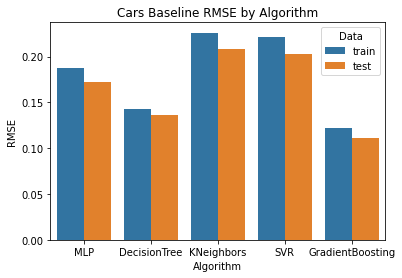

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import pickle

random_seed = 5295468
baseline = [MLPRegressor(random_state=random_seed, solver='adam'),
            DecisionTreeRegressor(random_state=random_seed),
            KNeighborsRegressor(n_neighbors=5, algorithm="ball_tree", n_jobs=-1),
            SVR(C = 1),
            GradientBoostingRegressor(random_state=random_seed)]

baseline_rmse_df = {'RMSE': [],
                    'Data': [],
                    'Algorithm': []}

for clf in tqdm(baseline):
    clf_name = clf.__class__.__name__.removesuffix("Regressor")

    scores = cross_val_score(clf, cars_scaled_train, prices_scaled_train, cv=5, scoring='neg_root_mean_squared_error')
    clf.fit(cars_scaled_train, prices_scaled_train)
    prices_test_pred = clf.predict(cars_scaled_test)
    
    error_test = mean_squared_error(prices_scaled_test, prices_test_pred, squared=False)
    baseline_rmse_df['Algorithm'].append(clf_name)
    baseline_rmse_df['Algorithm'].append(clf_name)
    baseline_rmse_df['RMSE'].append(-scores.mean())
    baseline_rmse_df['RMSE'].append(error_test)    
    baseline_rmse_df['Data'].append('train')
    baseline_rmse_df['Data'].append('test')
    
sns.barplot(x="Algorithm", y="RMSE", hue="Data", data=pd.DataFrame(baseline_rmse_df))
plt.title("Cars Baseline RMSE by Algorithm")
plt.savefig('Cars Baseline RMSE by Algorithm.png')


### Observations So Far

Using default parameters with the following data transformations:
* normalize the MSRP label distribution via log transformation
* leave one out encoding for the categorical parameters except Market Segment
* break out the Market Segment into one hot encoded features
* standard scaling all the features to a mean of 0 and std of 1
* determined the most correlated (and inversely correlated) features in the dataset
* PCA to determine how many features we could eliminate without reducing the dataset's variance too much
* Eliminate 8 of the features that were either highly correlated or were highly imbalanced to decrease the number of features from 25 to 17 without reducing the variance (from the previous PCA run)
* Dividing the data into training and test sets of 80/20.
* Run 5-fold cross validation of each algorithm for the training data and test data to compute baseline errors



### Cross Validation Observations



## Baseline Learning Curves (Attempt 1)

Before trying to reach optimal learning for each algorithm, I established baselines to work against.

To do this, I used default regressors from Scikit Learn, with default parameters, except where such defaults either resulted in errors or no default was provided.  In such cases, I chose "reasonable defaults".

Likewise, I used a random seed that is out of the ordinary, a text to phone number conversion of my name, "Jay Kint".  

To provide the contrast, we fed each algorithm percentages of the training data and then compared their RMSE for their predictions vs the training and test data respectively.  The following graphs show the results.

In [26]:
learning_curve_samples = []

for i in [1,2,5]:
    learning_curve_samples.append(int(i * cars_scaled_train.shape[0] / 100.))
    
for i in range(1,11):
    learning_curve_samples.append(int(i * 10 * cars_scaled_train.shape[0] / 100.))

In [27]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pickle

random_seed = 5295468
baseline = [MLPRegressor(random_state=random_seed, solver='adam'),
            DecisionTreeRegressor(random_state=random_seed),
            KNeighborsRegressor(5),
            SVR(C = 1),
            GradientBoostingRegressor(random_state=random_seed)]

learningcurve_results = {}
for clf in tqdm(baseline):
    clf_name = clf.__class__.__name__
    learningcurve_results[clf_name] = {'error_test':[],
                                       'error_train':[],
                                       'prices_train':[],
                                       'prices_test_pred': [], 
                                       'prices_train_pred': []}
    
    for i, sample in enumerate(learning_curve_samples):
        clf.fit(cars_scaled_train[:sample], prices_scaled_train[:sample])
        
        prices_test_pred = clf.predict(cars_scaled_test)
        prices_train_pred = clf.predict(cars_scaled_train[:sample])

        error_test = mean_squared_error(prices_scaled_test, prices_test_pred, squared=False)
        error_train = mean_squared_error(prices_scaled_train[:sample], prices_train_pred, squared=False)
        
        learningcurve_results[clf_name]['error_test'].append(error_test)
        learningcurve_results[clf_name]['error_train'].append(error_train)
        learningcurve_results[clf_name]['prices_train'].append(prices_train[:sample])
        learningcurve_results[clf_name]['prices_test_pred'].append(prices_test_pred)
        learningcurve_results[clf_name]['prices_train_pred'].append(prices_train_pred) 
        
        with open('car_prices_' + clf_name + '_' + str(sample) + '.pkl', 'wb') as f:
            pickle.dump(clf, f)

  0%|                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [28]:
# 
# import os

# for clf in baseline:
#     clf_name = clf.__class__.__name__
#     learningcurve_results[clf_name] = {'test':[],'train':[]}

#     for i, sample in enumerate(learning_curve_samples):
#         clf_name_file = ("car_prices_" + clf_name + '_{}.pkl').format(sample)
#         print(clf_name_file)
#         if(clf_name_file.find("car_prices_DecisionTree") == -1):
#             continue
#         if os.path.isfile(clf_name_file):
#             with open(clf_name_file, 'rb') as f:
#                 clf = pickle.load(f)
#         else:
#             raise(clf_name_file)

#         print(clf.get_depth())
#         print(clf.get_n_leaves())

In [29]:
learning_curve_samples

[94, 189, 472, 945, 1890, 2835, 3780, 4726, 5671, 6616, 7561, 8506, 9452]

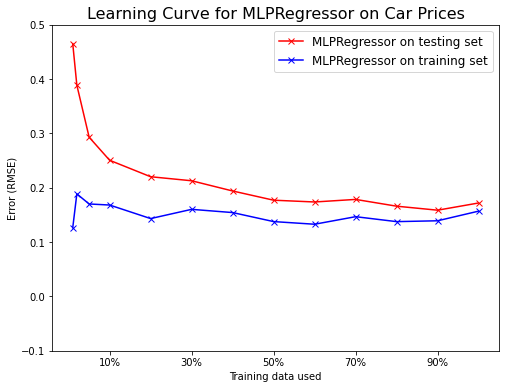

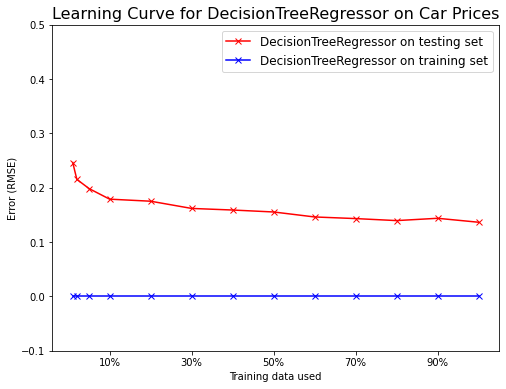

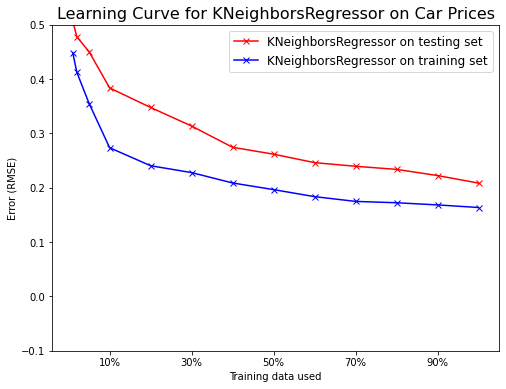

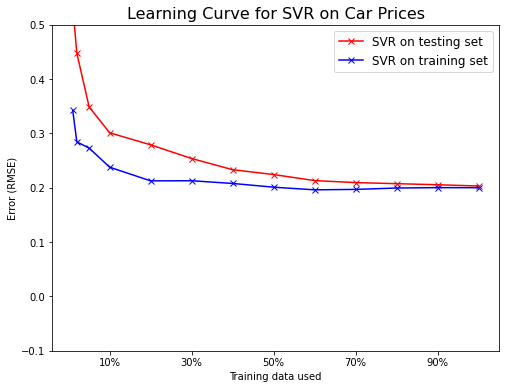

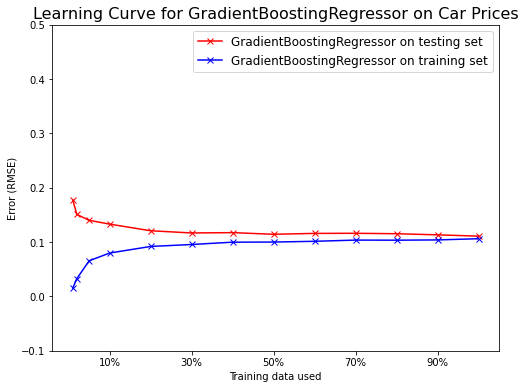

In [30]:
for clf in learningcurve_results.keys():
    x_data = [1,2,5,10,20,30,40,50,60,70,80,90,100]
    plt.figure(figsize = (8,6))
    plt.title('Learning Curve for {} on Car Prices'.format(clf),fontsize = 16)
    plt.plot(x_data,learningcurve_results[clf]['error_test'],'rx-', label = clf + ' on testing set' )
    plt.plot(x_data,learningcurve_results[clf]['error_train'],'bx-',label = clf + ' on training set')
    
    ticks = [10,30,50,70,90]
    plt.xticks(ticks,[str(x)+"%" for x in ticks])
    plt.xlabel("Training data used")
    plt.ylabel("Error (RMSE)")
    plt.ylim([-0.1, 0.5])
    plt.legend(loc="best",fontsize = 12);
    plt.savefig("Learning Curve for {} on Car Prices Data".format(clf))
    

In [31]:
dataset_name = 'Cars'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.63it/s]


Lowest MSE at 12 max_depth: 0.01492238155083523


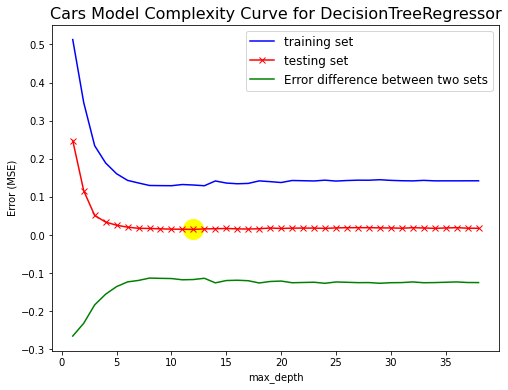

In [42]:
# Decision Tree
hyper_params = range(1, DecisionTreeRegressor(random_state = random_seed).fit(cars_scaled_train,prices_scaled_train).tree_.max_depth)
results = {'test':[], 'train':[]}
algorithm_name = 'DecisionTreeRegressor'

param_name = 'max_depth'

for i in tqdm(hyper_params):
    clf = DecisionTreeRegressor(random_state=random_seed, max_depth=i)
    
    clf.fit(cars_scaled_train, prices_scaled_train)
    train_error = -(cross_val_score(clf, cars_scaled_train, prices_scaled_train, cv=5, scoring='neg_root_mean_squared_error').mean())
    # train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format( hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('{} Model Complexity Curve for {}'.format(dataset_name, algorithm_name), fontsize = 16)

error_diff = pd.Series(np.array(results['test']) - np.array(results['train']))
plt.plot(hyper_params, results['train'],'b-',label = 'training set')
plt.plot(hyper_params, results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params,np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.legend(loc="best", fontsize = 12)

png_name = '{} Model Complexity Curve for {} ({}) .png'.format(dataset_name, algorithm_name, param_name)
plt.savefig(png_name)


  0%|                                                                                                                                                                                     | 0/7 [00:00<?, ?it/s]c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
 14%|████████████████████████▋                                                                                                                                                    | 1/7 [00:00<00:01,  3.20it/s]c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
 29%|█████████████████████████████████████████████████▍                                                                                           

Lowest MSE at 150 max_iter: 0.029552813278006733


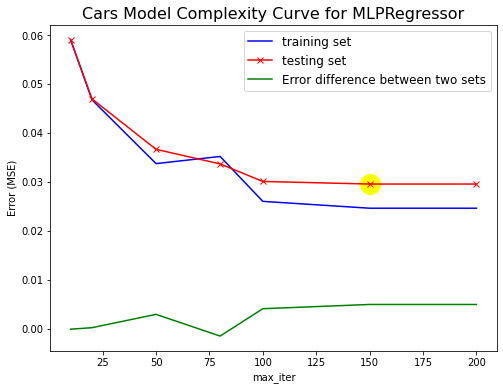

In [45]:
# Neural Network 
hyper_params = [10,20,50,80,100,150,200]
results = {'test':[], 'train':[]}
algorithm_name = 'MLPRegressor'

param_name = 'max_iter'

for i in tqdm(hyper_params):
    clf = MLPRegressor(random_state=random_seed, solver='adam', max_iter=i)
    clf.fit(cars_scaled_train, prices_scaled_train)

    train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    # train_error = -(cross_val_score(clf, cars_scaled_train, prices_scaled_train, cv=5, scoring='neg_root_mean_squared_error').mean())
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format( hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('Cars Model Complexity Curve for {}'.format(algorithm_name), fontsize = 16)

plt.plot(hyper_params,results['train'],'b-',label = 'training set')
plt.plot(hyper_params,results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params,np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.legend(loc="best", fontsize = 12)

png_name = 'Cars Model Complexity Curve for {} ({}).png'.format(algorithm_name, param_name)
plt.savefig(png_name)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.38s/it]


Lowest MSE at 2 n_neighbors: 0.0388209626624122


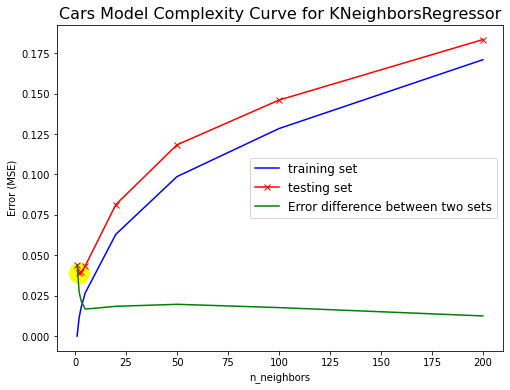

In [46]:
# kNN
hyper_params = [1, 2, 3, 5, 20, 50, 100, 200]
results = {'test':[], 'train':[]}
algorithm_name = 'KNeighborsRegressor'

param_name = 'n_neighbors'

for i in tqdm(hyper_params):
    np.random.seed(random_seed)
    clf = KNeighborsRegressor(n_neighbors=i)
    clf.fit(cars_scaled_train, prices_scaled_train)

    train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format(hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('Cars Model Complexity Curve for {}'.format(algorithm_name), fontsize = 16)

plt.plot(hyper_params, results['train'],'b-',label = 'training set')
plt.plot(hyper_params, results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params, np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.legend(loc="best", fontsize = 12)

png_name = 'Cars Model Complexity Curve for {} ({}) .png'.format(algorithm_name, param_name)
plt.savefig(png_name)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.36s/it]


Lowest MSE at 7 max_depth: 0.007758926655071294


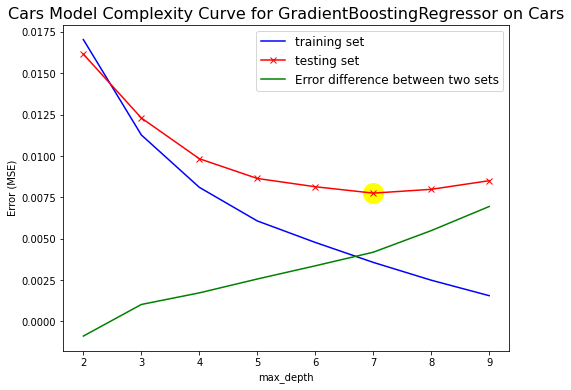

In [53]:
# Gradient Boosted Machines
hyper_params = range(2, 10)
results = {'test':[], 'train':[]}
algorithm_name = 'GradientBoostingRegressor'

param_name = 'max_depth'

for i in tqdm(hyper_params):
    clf = GradientBoostingRegressor(random_state=random_seed, max_depth=i)
    clf.fit(cars_scaled_train, prices_scaled_train)

    train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format( hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('Cars Model Complexity Curve for {}'.format(algorithm_name), fontsize = 16)

plt.plot(hyper_params, results['train'],'b-',label = 'training set')
plt.plot(hyper_params, results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params, np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.legend(loc="best", fontsize = 12)

png_name = 'Cars Model Complexity Curve for {} ({}) .png'.format(algorithm_name, param_name)
plt.savefig(png_name)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.79s/it]

Lowest MSE at rbf kernel: 0.04127614200190076


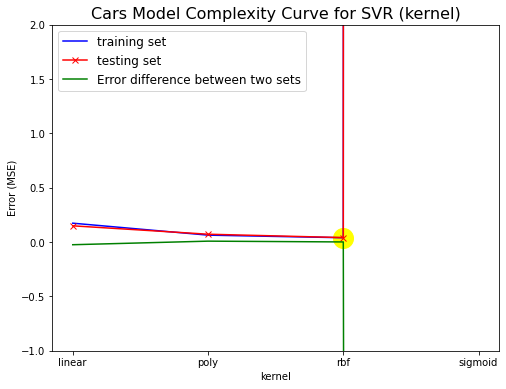

In [52]:
# SVM by kernel
hyper_params = ['linear', 'poly', 'rbf', 'sigmoid']
results = {'test':[], 'train':[]}
algorithm_name = 'SVR'

param_name = 'kernel'

for i in tqdm(hyper_params):
    np.random.seed(random_seed)
    clf = SVR(kernel=i)
    clf.fit(cars_scaled_train, prices_scaled_train)

    train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format( hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('Cars Model Complexity Curve for {} ({})'.format(algorithm_name, param_name), fontsize = 16)

plt.plot(hyper_params, results['train'],'b-',label = 'training set')
plt.plot(hyper_params, results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params, np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.ylim([-1, 2])
plt.legend(loc="best", fontsize = 12)

png_name = 'Cars Model Complexity Curve for {} ({}) .png'.format(algorithm_name, param_name)
plt.savefig(png_name)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:20<00:00, 22.27s/it]


Lowest MSE at 200.0 C: 0.032310732520101915


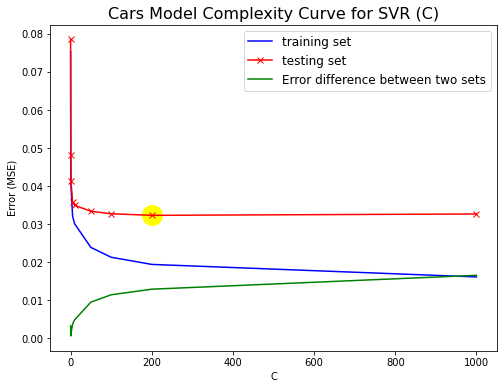

In [49]:
# SVM by C
hyper_params = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 200.0, 1000.0] # , 10000.0]
results = {'test':[], 'train':[]}
algorithm_name = 'SVR'

param_name = 'C'

for i in tqdm(hyper_params):
    np.random.seed(random_seed)
    clf = SVR(C=i)
    clf.fit(cars_scaled_train, prices_scaled_train)

    train_error = mean_squared_error(clf.predict(cars_scaled_train), prices_scaled_train)
    test_error = mean_squared_error(clf.predict(cars_scaled_test), prices_scaled_test)

    results['train'].append(train_error)
    results['test'].append(test_error)
    
opt = pd.Series(results['test']).idxmin() 
print("Lowest MSE at {} {}: {}".format( hyper_params[opt], param_name, results['test'][opt]))

plt.figure(figsize = (8,6))
plt.title('Cars Model Complexity Curve for {} ({})'.format(algorithm_name, param_name), fontsize = 16)

plt.plot(hyper_params, results['train'],'b-',label = 'training set')
plt.plot(hyper_params, results['test'],'rx-',label = 'testing set')
plt.plot(hyper_params, np.array(results['test']) - np.array(results['train']),'g-', label = 'Error difference between two sets')

opt = pd.Series(results['test']).idxmin()
plt.scatter(hyper_params[opt], results['test'][opt], s = 400, c = 'yellow')

plt.xlabel(param_name)
plt.ylabel("Error (MSE)")
plt.legend(loc="best", fontsize = 12)

png_name = 'Cars Model Complexity Curve for {} ({}) .png'.format(algorithm_name, param_name)
plt.savefig(png_name)

In [55]:
improved_clf = [MLPRegressor(random_state=random_seed, max_iter=100), 
                     DecisionTreeRegressor(random_state=random_seed, max_depth=12), 
                     KNeighborsRegressor(n_neighbors=2, n_jobs=-1, algorithm="ball_tree"),
                     SVR(C=10), 
                     GradientBoostingRegressor(random_state=random_seed, max_depth=6)]

  0%|                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maxim

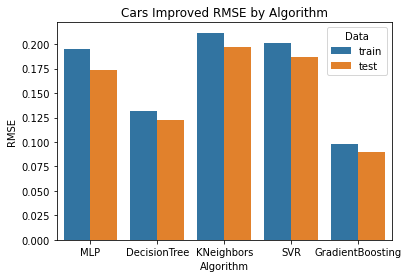

In [56]:
improved_rmse_df = {'RMSE': [],
                    'Data': [],
                    'Algorithm': []}

for clf in tqdm(improved_clf):
    clf_name = clf.__class__.__name__.removesuffix("Regressor")

    np.random.seed(random_seed)
    scores = cross_val_score(clf, cars_scaled_train, prices_scaled_train, cv=5, scoring='neg_root_mean_squared_error')
    clf.fit(cars_scaled_train, prices_scaled_train)
    prices_test_pred = clf.predict(cars_scaled_test)
    
    error_test = mean_squared_error(prices_scaled_test, prices_test_pred, squared=False)
    improved_rmse_df['Algorithm'].append(clf_name)
    improved_rmse_df['Algorithm'].append(clf_name)
    improved_rmse_df['RMSE'].append(-scores.mean())
    improved_rmse_df['RMSE'].append(error_test)    
    improved_rmse_df['Data'].append('train')
    improved_rmse_df['Data'].append('test')
    
sns.barplot(x="Algorithm", y="RMSE", hue="Data", data=pd.DataFrame(improved_rmse_df))
plt.title("Cars Improved RMSE by Algorithm")
plt.savefig('Cars Improved RMSE by Algorithm.png')

In [57]:
print(baseline_rmse_df)
print(improved_rmse_df)

{'RMSE': [0.18753852534138693, 0.17190931701919687, 0.14244846046488688, 0.13649375672490183, 0.2259787409349266, 0.2084637484133284, 0.2212166787835665, 0.2031653070824366, 0.1224236989905837, 0.11091799848399148], 'Data': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'], 'Algorithm': ['MLP', 'MLP', 'DecisionTree', 'DecisionTree', 'KNeighbors', 'KNeighbors', 'SVR', 'SVR', 'GradientBoosting', 'GradientBoosting']}
{'RMSE': [0.19465119517825466, 0.17345144471337443, 0.1314131709047216, 0.12215720015961086, 0.21171219728383214, 0.19703035974796423, 0.20076977641238467, 0.18694683359041284, 0.09835126041272792, 0.09024478232498448], 'Data': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'], 'Algorithm': ['MLP', 'MLP', 'DecisionTree', 'DecisionTree', 'KNeighbors', 'KNeighbors', 'SVR', 'SVR', 'GradientBoosting', 'GradientBoosting']}


## Decision Tree

Decision trees are among the simplest and easily intepreted algorithms for developing models.

Below we use XGBoost to train a gradient-boosted decision tree: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

In [ ]:
from sklearn.tree import DecisionTreeRegressor
np.random.seed(5295468)
model_skl = DecisionTreeRegressor()
model_skl.fit(cars_train, prices_train)

In [ ]:
prices_pred = model_skl.predict(cars_test)
np.sqrt(np.mean((prices_test - prices_pred)**2))

In [ ]:
cars_reconstituted = pd.DataFrame(scaler.inverse_transform(cars_df_scaled))
cars_reconstituted.columns = cars_df.columns
cars_reconstituted['msrp'] = np.expm1(cars_reconstituted['msrp'])
cars_reconstituted
# cars_recontituded = pd.DataFrame(scaler.inverse_transform(prices_pred))
# cars_reconstituted.columns = cars_df.columns
# cars_reconstituted['msrp'] = np.expm1(cars_reconstituted['msrp'])
# cars_reconstituted

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipe_steps = [('decsT', DecisionTreeRegressor())] # [('scaler', StandardScaler()), ('decsT', DecisionTreeClassifier())]
check_params = {'decsT__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                'decsT__max_depth': np.arange(3, 25),
                'decsT__max_features': ['auto', 'sqrt', 'log2']}
pipeline = Pipeline(pipe_steps)
print(pipeline)

In [ ]:
from tqdm.notebook import tqdm
np.random.seed(5295468)
print('Start fitting the data')

for cv in tqdm(range(3,11)):
    grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv, 
                        n_jobs=-1, scoring='explained_variance')
    grid.fit(cars_train, prices_train)
    print('Score for %d fold CV = %f' % (cv, grid.score(cars_test, prices_test)))
    print('best parameters = {}'.format(grid.best_params_))
    # print('individual scores = {}'.format(grid.cv_results_))
print('Done')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

xgb_model = xgb.XGBRegressor(n_jobs=1, n_estimator=1, random_state=5295468)
pipe_steps=[('decsT', xgb_model)]
check_params = {'decsT__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                'decsT__max_depth': np.arange(3, 25),
                'decsT__max_features': ['auto', 'sqrt', 'log2']}
pipeline = Pipeline(pipe_steps)
print(pipeline)

In [ ]:
from tqdm.notebook import tqdm
np.random.seed(5295468)
print('Start fitting the data')

for cv in tqdm(range(3,11)):
    grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv, 
                        n_jobs=-1, scoring='explained_variance')
    grid.fit(cars_train, prices_train)
    print('Score for %d fold CV = %f' % (cv, grid.score(cars_test, prices_test)))
    print('best parameters = {}'.format(grid.best_params_))
    # print('individual scores = {}'.format(grid.cv_results_))
print('Done')

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# cars_features_df = cars_df.loc[:,cars_df.columns != 'msrp']
# cars_labels_df = cars_df['msrp']
# sss = StratifiedShuffleSplit(cars_labels_df.values, test_size = 0.02, random_state = 5295468)

# (cars_train_idx, cars_test_idx) = sss.split(cars_features_df, cars_labels_df)

# # for train_index, test_index in sss:
# #     cars_train, cars_test = cars_features_df.values[train_index], cars_features_df.values[test_index]
# #     prices_train, prices_test = cars_labels_df.values[train_index], cars_labels_df.values[test_index]
    
# # Show the results of splitting
# print("Cars dataset training size: {}".format(cars_train.shape))
# print("Cars dataset test size: {}".format(cars_test.shape))